<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Behavioral_Data_Analysis/blob/master/%EB%B2%88%EC%99%B8_Camera%EB%B3%80%EC%88%98_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94_%EC%A0%81%EC%9A%A9%ED%9B%84_t_SNE_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
print( '변경 전 기본 경로 :' )
print(  os.getcwd() )
os.chdir('./drive/My Drive/데이콘_게임데이터분석')
print( '변경 후 파일 경로 :' )
print(  os.getcwd()  )

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook              # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
#from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시


변경 전 기본 경로 :
/content
변경 후 파일 경로 :
/content/drive/My Drive/데이콘_게임데이터분석


In [0]:
%time
x_train = pd.read_pickle('x_train.pkl')
camera_list = x_train.camera_list

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


## player0 와 player1 좌표의 최댓값을 구하기

In [0]:
def get_min_max(camera_list = camera_list):
  max_p0 = 10
  max_p1 = 10
  min_p0 = 10
  min_p1 = 10
  from tqdm import tqdm_notebook
  for i in tqdm_notebook(range( len(camera_list) )):  #
    if str(camera_list[i]['player0']) != 'nan':
      max_p0_i = camera_list[i]['player0'][:,0].max()
      min_p0_i = camera_list[i]['player0'][:,0].min()
    else:
      print(f'{i}번째 게임에서 플레이어0의 좌표가 없음')
      max_p0_i = 10
      min_p0_i = 10
    if str(camera_list[i]['player1']) != 'nan':
      max_p1_i = camera_list[i]['player1'][:,0].max()
      min_p1_i = camera_list[i]['player1'][:,0].min()
    else:
      print(f'{i}번째 게임에서 플레이어1의 좌표가 없음')
      max_p1_i=10
      min_p1_i=10

    max_p0 = max(max_p0 , max_p0_i)
    max_p1 = max(max_p1 , max_p1_i)
    min_p0 = min(min_p0 , min_p0_i)
    min_p1 = min(min_p1 , min_p1_i)
  return max_p0, max_p1, min_p0, min_p1

max_p0, max_p1, min_p0, min_p1 = get_min_max(camera_list = camera_list)


In [0]:
print(max_p0)
print(max_p1)
print(min_p0)
print(min_p1)


169.0
169.0
0.0
0.0


## player0 와 player1 따로 좌표 차지하는 곳 0 1로 찍기 (MNIST 데이터처럼)

In [0]:
############### 모든 게임 전체를 저장할 비어있는 어레이
total_array = np.zeros( 38872*(175+175)*175  )
total_array = total_array.reshape(  38872,(175+175),175 )

################ player0과1에 대한 코드 #################
## 한 게임당 player0과 1모두를 저장할 어레이 1~175 : 플레이어0, 171~340 : 플레이어1
arr_i_p = np.zeros((175+175)*175).reshape((175+175),175)

############ i에 대한 for문 시작
## i번째 게임에서 player의 좌표들
i = 0
player = 'player0'
camera_p0_i = camera_list[i]['player0'].astype(int)
player = 'player1'
camera_p1_i = camera_list[i]['player0'].astype(int)


#################### j에 대한 for문 시작
## i번째 게임에서 player의 좌표들 중 j번째 좌표
j = 15
indexing_p0_ij = camera_p0_i[j].tolist()
indexing_p1_ij = camera_p1_i[j].tolist()

arr_i_p[indexing_p0_ij[0],indexing_p0_ij[1]] = 1
arr_i_p[indexing_p1_ij[0]+170,indexing_p1_ij[1]] = 1

total_array[i,:,:] = arr_i_p

In [0]:

def array_0and1(camera_list = camera_list):
  m = 180
  ############### 모든 게임 전체를 저장할 비어있는 어레이
  total_array = np.zeros( len(camera_list)*(m+m)*m  )
  total_array = total_array.reshape(  len(camera_list),(m+m),m )

  ############ i에 대한 for문 시작
  from tqdm import tqdm_notebook
  for i in tqdm_notebook( range( len(camera_list) ) ):
    ################ i번째 게임에서 player0과1 모두에 대한 코드 #################
    ## 한 게임당 player0과 1모두를 저장할 어레이 1~170 : 플레이어0, 171~340 : 플레이어1
    arr_i_p = np.zeros((m+m)*m)
    arr_i_p = arr_i_p.reshape((m+m),m)

    ## player0의 좌표들 1로 채워넣는 코드##
    if str(camera_list[i]['player0']) != 'nan':
      for j in range(len(camera_list[i]['player0'])):
        ## i번째 게임에서 player0의 좌표들 중 j번째 좌표
        indexing_p0_ij = camera_list[i]['player0'].astype(int)[j].tolist()

        ################ player0에 대한 좌표들을 모두 1로 채워넣기 ################
        arr_i_p[indexing_p0_ij[0],indexing_p0_ij[1]] = 1
    else:
      print(f'{i}번째 게임에서 플레이어0의 좌표가 없음')
    ## player1의 좌표들 1로 채워넣는 코드 ##
    if str(camera_list[i]['player1']) != 'nan':
      for j in range(len(camera_list[i]['player1'])):
        ## i번째 게임에서 player1의 좌표들 중 j번째 좌표
        indexing_p1_ij = camera_list[i]['player1'].astype(int)[j].tolist()

        ################ player1에 대한 좌표들을 모두 1로 채워넣기 ################
        arr_i_p[indexing_p1_ij[0]+170,indexing_p1_ij[1]] = 1
    else:
      print(f'{i}번째 게임에서 플레이어1의 좌표가 없음')

    total_array[i,:,:] = arr_i_p

  return total_array

In [0]:
array0and1 = array_0and1(camera_list = camera_list)
array0and1.shape
#np.save('array0and1', array0and1)

187번째 게임에서 플레이어1의 좌표가 없음
10246번째 게임에서 플레이어0의 좌표가 없음
12105번째 게임에서 플레이어1의 좌표가 없음
13292번째 게임에서 플레이어1의 좌표가 없음
14675번째 게임에서 플레이어1의 좌표가 없음
17294번째 게임에서 플레이어1의 좌표가 없음
21149번째 게임에서 플레이어0의 좌표가 없음
23337번째 게임에서 플레이어0의 좌표가 없음
24423번째 게임에서 플레이어1의 좌표가 없음
24855번째 게임에서 플레이어1의 좌표가 없음
24858번째 게임에서 플레이어1의 좌표가 없음
25891번째 게임에서 플레이어0의 좌표가 없음
26243번째 게임에서 플레이어1의 좌표가 없음
26339번째 게임에서 플레이어1의 좌표가 없음
27249번째 게임에서 플레이어1의 좌표가 없음
27818번째 게임에서 플레이어0의 좌표가 없음
32254번째 게임에서 플레이어1의 좌표가 없음
33101번째 게임에서 플레이어1의 좌표가 없음
34423번째 게임에서 플레이어1의 좌표가 없음
34843번째 게임에서 플레이어1의 좌표가 없음
35288번째 게임에서 플레이어0의 좌표가 없음
37967번째 게임에서 플레이어1의 좌표가 없음



(38872, 360, 180)

## t-SNE 적용 (너무 오래걸려서 실패)

In [0]:
camera_df = pd.read_pickle('camera_array.pkl')
camera_df.head()
print(camera_df.shape)
print(camera_df.info())
camera_array = np.array(camera_df)
camera_array.shape
del camera_df

(38872, 7884)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38872 entries, 0 to 38871
Columns: 7884 entries, 0 to 7883
dtypes: float64(7884)
memory usage: 2.3 GB
None


In [0]:
max_0 = 3664    # player0 은 0부터    3664 열 까지
max_1 = 4220    # player1 은 3665부터 7884까지

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print(camera_array.shape)

tsne = TSNE(n_components=2,random_state=0, verbose=1)
camera_array_tsne = tsne.fit_transform(camera_array)

print(camera_array_tsne.shape)


(38872, 7884)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38872 samples in 57.482s...


In [0]:
matplotlib.rc('font', family='AppleGothic') # 한글 출력

colors = ['#476A2A', '#7851B8']

# 시각화
for i in range(len(winner)): # 0부터  digits.data까지 정수
    plt.text(camera_array_tsne[i, 0], camera_array_tsne[i, 1], str(winner[i]), # x, y , 그룹
             color=colors[winner[i]], # 색상
             fontdict={'weight': 'bold', 'size':9}) # font

plt.xlim(camera_array_tsne[:, 0].min(), camera_array_tsne[:, 0].max()) # 최소, 최대
plt.ylim(camera_array_tsne[:, 1].min(), camera_array_tsne[:, 1].max()) # 최소, 최대
plt.xlabel('t-SNE 특성0') # x축 이름
plt.ylabel('t-SNE 특성1') # y축 이름
plt.show() # 그래프 출력

## 오토인코더로 차원축소

In [0]:
camera_df = pd.read_pickle('camera_array.pkl')
camera_df.head()
print(camera_df.shape)
print(camera_df.info())
camera_array = np.array(camera_df)
print(camera_array.shape)
del camera_df

from sklearn.preprocessing import minmax_scale

train_scaled = minmax_scale(camera_array, feature_range=(0, 1),axis = 0)
#test_scaled = minmax_scale(test_x, feature_range=(0, 1),axis = 0)

from sklearn.model_selection import train_test_split
from numpy.random import seed

X_train, X_test = train_test_split(train_scaled,  train_size = 0.9, random_state = seed(2020))


(38872, 7884)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38872 entries, 0 to 38871
Columns: 7884 entries, 0 to 7883
dtypes: float64(7884)
memory usage: 2.3 GB
None
(38872, 7884)


In [0]:
import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout , Lambda, Flatten, LeakyReLU, ELU
from keras.layers import Concatenate, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD,RMSprop
from tensorflow.keras import  backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import BatchNormalization # 배치정규화
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from tensorflow.keras.models import Model
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Activation(gelu)})

encoding_dim = 100
ncol = camera_array.shape[1]
input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(7328, activation = 'elu')(input_dim)
encoded2 = Dense(6772, activation = 'elu')(encoded1)
encoded3 = Dense(6216, activation = 'elu')(encoded2)
encoded4 = Dense(5660, activation = 'elu')(encoded3)
encoded5 = Dense(5104, activation = 'elu')(encoded4)
encoded6 = Dense(4548, activation = 'elu')(encoded5)
encoded7 = Dense(3992, activation = 'elu')(encoded6)
encoded8 = Dense(3436, activation = 'elu')(encoded7)
encoded9 = Dense(2880, activation = 'elu')(encoded8)
encoded10 = Dense(2324, activation = 'elu')(encoded9)
encoded11 = Dense(1768, activation = 'elu')(encoded10)
encoded12 = Dense(1212, activation = 'elu')(encoded11)
encoded13 = Dense(656, activation = 'elu')(encoded12)
encoded14 = Dense(encoding_dim, activation = 'elu')(encoded13)

# Decoder Layers
decoded1 = Dense(656, activation = 'elu')(encoded14)
decoded2 = Dense(1212, activation = 'elu')(decoded1)
decoded3 = Dense(1768, activation = 'elu')(decoded2)
decoded4 = Dense(2324, activation = 'elu')(decoded3)
decoded5 = Dense(2880, activation = 'elu')(decoded4)
decoded6 = Dense(3436, activation = 'elu')(decoded5)
decoded7 = Dense(3992, activation = 'elu')(decoded6)
decoded8 = Dense(4548, activation = 'elu')(decoded7)
decoded9 = Dense(5104, activation = 'elu')(decoded8)
decoded10 = Dense(5660, activation = 'elu')(decoded9)
decoded11 = Dense(6216, activation = 'elu')(decoded10)
decoded12 = Dense(6772, activation = 'elu')(decoded11)
decoded13 = Dense(7328, activation = 'elu')(decoded12)
decoded14 = Dense(ncol, activation = 'linear')(decoded13)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded14)

# Compile the Model
autoencoder.compile(optimizer = Adam(lr=1e-5), loss = 'mae', metrics=['mse'])
#autoencoder.summary()
early_stop = EarlyStopping(monitor= 'val_loss', patience = 20, verbose = 1)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## AE의 MSE가 0.01보다도 작음 (RMSE가 0.1보다도 작음) => 너무 잘 되는듯? 좋음
## + 혹시 train_y에 바로 0,1을 예측하는건 효과가 어떨까??

In [0]:
hist = autoencoder.fit(X_train, X_train, epochs = 10, batch_size = 16, shuffle = False, validation_data = (X_test, X_test)  #,callbacks=[early_stop]
                       )

Train on 34984 samples, validate on 3888 samples
Epoch 1/10
34984/34984 [==============================] - 159s 5ms/sample - loss: 0.0529 - mean_squared_error: 0.0191 - val_loss: 0.0429 - val_mean_squared_error: 0.0133
Epoch 2/10
34984/34984 [==============================] - 157s 4ms/sample - loss: 0.0401 - mean_squared_error: 0.0122 - val_loss: 0.0394 - val_mean_squared_error: 0.0115
Epoch 3/10
34984/34984 [==============================] - 156s 4ms/sample - loss: 0.0373 - mean_squared_error: 0.0109 - val_loss: 0.0371 - val_mean_squared_error: 0.0109
Epoch 4/10
34984/34984 [==============================] - 156s 4ms/sample - loss: 0.0357 - mean_squared_error: 0.0103 - val_loss: 0.0370 - val_mean_squared_error: 0.0105
Epoch 5/10
34984/34984 [==============================] - 158s 5ms/sample - loss: 0.0347 - mean_squared_error: 0.0098 - val_loss: 0.0352 - val_mean_squared_error: 0.0100
Epoch 6/10
34984/34984 [==============================] - 158s 5ms/sample - loss: 0.0338 - mean_squar

In [0]:
encoder = Model(inputs = input_dim, outputs = encoded14)
encoded_input = Input(shape = (encoding_dim, ))

encoded_train = pd.DataFrame(encoder.predict(train_scaled))
encoded_train = encoded_train.add_prefix('auto_feature_')

#encoded_test = pd.DataFrame(encoder.predict(test_scaled))
#encoded_test = encoded_test.add_prefix('auto_feature_')

encoded_train.to_pickle('camera_auto_encoded.pkl')
print(encoded_train.describe())

       auto_feature_0  auto_feature_1  ...  auto_feature_98  auto_feature_99
count    38872.000000    38872.000000  ...     38872.000000     38872.000000
mean         0.728568       -0.539706  ...        -0.821923         0.337681
std          0.404640        0.706691  ...         0.102313         1.025653
min         -0.688659       -0.968208  ...        -0.978189        -0.960626
25%          0.472747       -0.933194  ...        -0.887633        -0.726421
50%          0.718760       -0.897078  ...        -0.848816         0.319790
75%          1.000459       -0.550777  ...        -0.788979         1.338249
max          2.159030        2.462336  ...         0.023770         2.342477

[8 rows x 100 columns]


In [0]:
loss_and_metric = autoencoder.evaluate(train_scaled, train_scaled, batch_size=16, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))

train, loss and metric: [0.03230094443604175, 0.008581218]


### 오토인코더 결과 t-SNE로 확인해보기

In [0]:
max_0 = 3664    # player0 은 0부터    3664 열 까지
max_1 = 4220    # player1 은 3665부터 7884까지

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

print(encoded_train.shape)

tsne = TSNE(n_components=2,random_state=0, verbose=1)
encoded_train_tsne = tsne.fit_transform(encoded_train)

print(encoded_train_tsne.shape)


(38872, 100)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38872 samples in 0.620s...
[t-SNE] Computed neighbors for 38872 samples in 124.973s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38872
[t-SNE] Computed conditional probabilities for sample 2000 / 38872
[t-SNE] Computed conditional probabilities for sample 3000 / 38872
[t-SNE] Computed conditional probabilities for sample 4000 / 38872
[t-SNE] Computed conditional probabilities for sample 5000 / 38872
[t-SNE] Computed conditional probabilities for sample 6000 / 38872
[t-SNE] Computed conditional probabilities for sample 7000 / 38872
[t-SNE] Computed conditional probabilities for sample 8000 / 38872
[t-SNE] Computed conditional probabilities for sample 9000 / 38872
[t-SNE] Computed conditional probabilities for sample 10000 / 38872
[t-SNE] Computed conditional probabilities for sample 11000 / 38872
[t-SNE] Computed conditional probabilities for sample 12000 / 38872
[t-SNE] Computed conditional probab

In [0]:
#pd.DataFrame(encoded_train_tsne).to_pickle('encoded_train_tsne.pkl')
encoded_train_tsne = pd.read_pickle('encoded_train_tsne.pkl')
encoded_train_tsne = np.array(encoded_train_tsne)
%time
newtrain = pd.read_pickle('newtrain.pkl')
print(newtrain.shape)
winner = newtrain['winner']

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
(38872, 47)


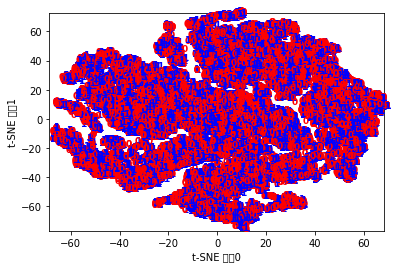

In [0]:

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='AppleGothic') # 한글 출력

colors = ['red', 'blue']

from tqdm import tqdm_notebook
# 시각화
for i in  tqdm_notebook( range(len(winner)) ): # 0부터  digits.data까지 정수
    plt.text(encoded_train_tsne[i, 0], encoded_train_tsne[i, 1], str(winner[i]), # x, y , 그룹
             color=colors[winner[i]], # 색상
             fontdict={'weight': 'bold', 'size':9}) # font

plt.xlim(encoded_train_tsne[:, 0].min(), encoded_train_tsne[:, 0].max()) # 최소, 최대
plt.ylim(encoded_train_tsne[:, 1].min(), encoded_train_tsne[:, 1].max()) # 최소, 최대
plt.xlabel('t-SNE 특성0') # x축 이름
plt.ylabel('t-SNE 특성1') # y축 이름
plt.show() # 그래프 출력